In [168]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
import os
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import japanize_matplotlib as jm

In [ ]:
import urllib.request
import gzip
import numpy as np
import pickle


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}
dataset_dir = './mnist'    #データを保存する場所

for v in key_file.values():
    file_path = dataset_dir + '/' + v
    urllib.request.urlretrieve(url_base + v, file_path)

def load_img(file_name):
    file_path = dataset_dir + '/' + file_name
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 784)

    return data

def load_label(file_name):
    file_path = dataset_dir + '/' + file_name
    with gzip.open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)

    return labels

dataset = {}
dataset['train_img'] = load_img(key_file['train_img'])
dataset['train_label'] = load_label(key_file['train_label'])
dataset['test_img'] = load_img(key_file['test_img'])
dataset['test_label'] = load_label(key_file['test_label'])

save_file = dataset_dir + '/mnist.pkl'    #拡張子は.pkl
with open(save_file, 'wb') as f:
    pickle.dump(dataset, f, -1)    #-1は最も高いプロトコルバージョンで保存することを指定している


## 2.3　パーセプトロンの実装  
* パーセプトロンとは、複数の0,1入力をもとに1つの0,1出力を返すアルゴリズムのこと

In [1]:
def AND(x1,x2):
    w1, w2, theta = .5, .5, .7
    tmp = x1 * w1 + x2 * w2 - theta
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1

In [3]:
print(AND(0,0))
print(AND(1,1))
print(AND(1,0))
print(AND(0,1))

0
1
0
0


* 重みとバイアスを導入。行列式の形にする

2つの入力値$x_1,x_2$について、それぞれに対応する重み$w_1, w_2$をかけた和とバイアス($b$)の大小で出力を判断する。  
$$
y=
\left\{
\begin{array}{ll}
0 & (b + w_1 x_1 + w_2 x_2) \leqq 0 \\
1 & (b + w_1 x_1 + w_2 x_2) > 0
\end{array}
\right.
$$

In [13]:
def AND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([.5, .5])
    b = -.7
    tmp = b + np.sum(x * w)
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1

In [14]:
for m in range(2):
    for n in range(2):
        print(f'{[m,n]} -> {AND(m,n)}')

[0, 0] -> 0
[0, 1] -> 0
[1, 0] -> 0
[1, 1] -> 1


- 重み$w_n$は対応する入力値$x_n$それぞれの重要度を制御  
- バイアス$b$はそのニューロンの発火しやすさを制御

In [23]:
def NAND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([-.5, -.5])
    b = .7
    tmp = b + np.sum(x * w)
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1

print('NAND')
for m in range(2):
    for n in range(2):
        print(f'{[m,n]} -> {NAND(m,n)}')

NAND
[0, 0] -> 1
[0, 1] -> 1
[1, 0] -> 1
[1, 1] -> 0


In [33]:
def OR(x1, x2):
    x = np.array([x1, x2])
    w = np.array([.5, .5])
    b = -.2
    tmp = b + np.sum(x * w)
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1

print('NAND')
for m in range(2):
    for n in range(2):
        print(f'{[m,n]} -> {OR(m,n)}')

NAND
[0, 0] -> 0
[0, 1] -> 1
[1, 0] -> 1
[1, 1] -> 1


* XOR:排他的論理和  
これは線型のパーセプトロンでは実装できない

| $x_1$ | $x_2$ | $y$ |  
| :---: | :---: | :---: |  
| 0 | 0 | 0 |  
| 1 | 0 | 1 |  
| 0 | 1 | 1 |  
| 1 | 1 | 0 |  

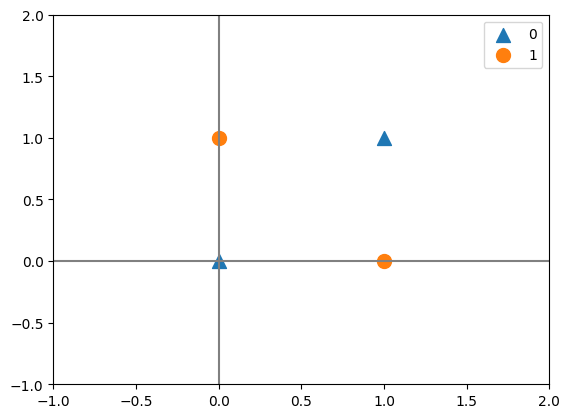

In [56]:
plt.xlim([-1,2])
plt.ylim([-1,2])
plt.hlines(y=0,xmin=-5,xmax=5,colors='gray')
plt.vlines(x=0,ymin=-5,ymax=5,colors='gray')
plt.scatter(x=[0,1],y=[0,1],marker='^',s=100,label='0')
plt.scatter(x=[0,1],y=[1,0],marker='o',s=100,label='1')
plt.legend(loc='best')


* 上の図で、三角(出力が0)と丸(出力が1)を分ける直線が引けない

### 多層パーセプトロン
* パーセプトロンを組み合わせることで非線形の分離を実装可能  

In [63]:
def XOR(x1,x2):
    s1 = OR(x1,x2)
    s2 = NAND(x1,x2)
    y = AND(s1,s2)
    return y

print('XOR')
for m in range(2):
    for n in range(2):
        print(f'{[m,n]} -> AND:{AND(m,n)}, NAND:{NAND(m,n)}, OR:{OR(m,n)}, XOR:{XOR(m,n)}')

XOR
[0, 0] -> AND:0, NAND:1, OR:0, XOR:0
[0, 1] -> AND:0, NAND:1, OR:1, XOR:1
[1, 0] -> AND:0, NAND:1, OR:1, XOR:1
[1, 1] -> AND:1, NAND:0, OR:1, XOR:0


* 線型なパーセプトロンでも多層にすることで非線形な表現が可能。
* でも今のところ、パラメータ(重みやバイアス)の値は人間が期待する出力に合わせて調整している
* 最適なパラメータをデータから学習させることを考える

### ニューラルネットワーク

$$
y=
\left\{
\begin{array}{ll}
0 & (b + w_1 x_1 + w_2 x_2) \leqq 0 \\
1 & (b + w_1 x_1 + w_2 x_2) > 0
\end{array}
\right.
$$
を、以下のように変換する  

$$
a= b + w_1 x_1 + w_2 x_2
$$
$$
h(x) = \left\{
\begin{array}{ll}
0 & x \leqq 0 \\
1 & x > 0
\end{array}
\right.
$$
$$
y = h(a)
$$

$a$ : 入力信号の重み付き和(バイアス含む)を計算  
$h(x)$ : そのニューロンが発火する条件が指定されている**活性化関数**  
$y$ : 入力の重み付き和を活性化関数に引き渡した結果の出力  

* 活性化関数はさまざまな関数たりうるが、パーセプトロンはある閾値で出力が切り替わる**ステップ関数**を活性化関数として採用したNNだと言える
* ニューラルネットワークでは一般的に**シグモイド関数**が使われる  

$$
h(x)=\frac{1}{1+\exp(-x)}
$$

* ステップ関数とシグモイド関数を比較

In [72]:
def step_function(x:np.array):
    y = x > 0
    return y.astype(int)
def sigmoid(x:np.array):
    y = 1/(1+np.exp(-x))
    return y

In [70]:
x = np.array([1,0,.5,1.4,50])
step_function(x)

array([1, 0, 1, 1, 1])

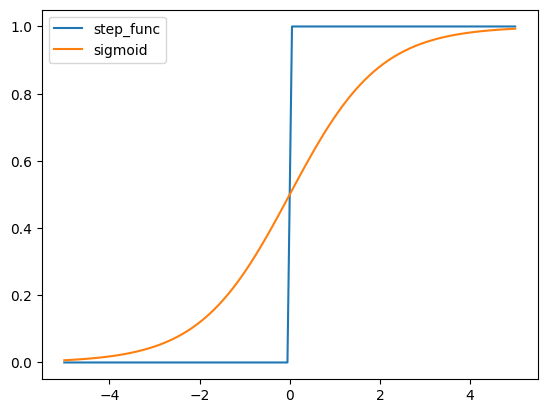

In [76]:
x=np.linspace(-5,5,100)
y_step=step_function(x)
y_sig=sigmoid(x)
plt.plot(x,y_step,label='step_func')
plt.plot(x,y_sig, label = 'sigmoid')
plt.legend(loc ='best')

- 最近のNNではReLU関数という関数が活性化関数で使われることが多い。<ins>**Re**</ins>ctified <ins>**L**</ins>inear <ins>**U**</ins>nit
$$
y=
\left\{
\begin{array}{ll}
0 & x\leqq 0 \\
x & x > 0
\end{array}
\right.
$$

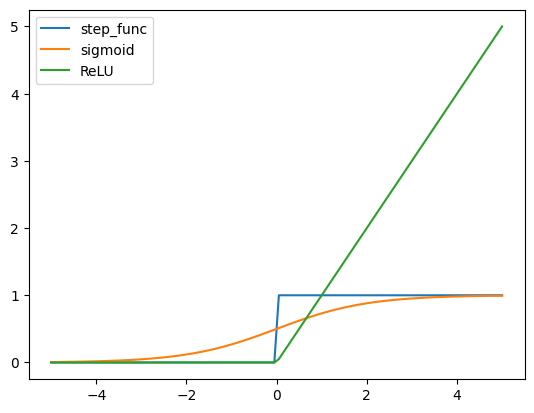

In [77]:
def relu(x):
    return np.maximum(x,0)

x=np.linspace(-5,5,100)
y_step=step_function(x)
y_sig=sigmoid(x)
y_relu=relu(x)
plt.plot(x,y_step,label='step_func')
plt.plot(x,y_sig, label = 'sigmoid')
plt.plot(x,y_relu, label = 'ReLU')
plt.legend(loc ='best')

### 多次元配列の計算

- NNの計算を行列で行うと１発で計算できる。
- 2つのインプット$x_1,x_2$に対して、それぞれ[$w_{11},w_{21}$],[$w_{12},w_{22}$],[$w_{13},w_{23}$]の重み付けをした出力$y_1,y_2,y_3$は以下のように求められる。

$$
\begin{pmatrix}
x_1 & x_2 \\
\end{pmatrix}
\begin{pmatrix}
w_{11} & w_{12} & w_{13}\\
w_{21} & w_{22} & w_{23}\\
\end{pmatrix}
=
\begin{pmatrix}
y_1=x_1 \times w_{11}+x_2 \times w_{21} & y_2=x_1 \times w_{12}+x_2 \times w_{22} & y_3=x_1 \times w_{13}+x_2 \times w_{23}
\end{pmatrix}
$$

入力ベクトルのn番目のニューロンを出力ベクトルのm番目にするためにかかる重みwを$w_{nm}$

- おさらい  
入力に重みをかけてバイアスを足した値を活性化関数にかけた出力が出力値  
$$
output = h(input \times weight + bias)
$$
$$
Y=h(X \times W + B)
$$

### 適当な実装

#### まずは重み付き和

In [97]:
X = np.array([1.0, 0.5])
W1 = np.array([
    [.1, .3, .5],
    [.2, .4, .6]
])
B1 = np.array([.1, .2, .3])
A1 =np.dot(X, W1) + B1
A1

array([0.3, 0.7, 1.1])

#### 次に活性化関数 -> 第一層

In [98]:
Z1 = sigmoid(A1)
Z1

array([0.57444252, 0.66818777, 0.75026011])

#### 第１層の重み付き和→第二層へ

In [99]:
W2 = np.array([
    [.1, .4],
    [.2, .5],
    [.3, .6]
])
B2 = np.array([.1, .2])
A2 = np.dot(Z1,W2) + B2
Z2 = sigmoid(A2)

In [100]:
def identify_function(x):
    return x

#### 出力

In [101]:
W3 = np.array([
    [.1, .3],
    [.2, .4]
])
B2 = np.array([.1, .2])

Y = identify_function(np.dot(Z2,W3) + B2)
Y

array([0.31682708, 0.69627909])

#### ここまでを一気に実装する

In [44]:
def sigmoid(x:np.array):
    return 1/(1+np.exp(-x))

def identify_function(x):
    return x

def init_network():
    network = {}
    network['W1']=np.array([
        [.1, .3, .5],
        [.2, .4, .5],
    ])
    network['b1']=np.array([.1, .2, .3])
    network['W2']=np.array([
        [.1, .4],
        [.2, .5],
        [.3, .6]
    ])
    network['b2']=np.array([.1, .2])
    network['W3']=np.array([
        [.1, .3],
        [.2, .4]
    ])
    network['b3']=np.array([.1, .2])
    return network

def forward(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = identify_function(a3)
    return y

In [103]:
network = init_network()
x=(1, .5)
y = forward(network, x)
print(y)

[0.31655918 0.69567667]


## 3.5 出力層

ニューラルネットワークは出力層を変えることで回帰にも分類にも応用可能。  
一般的に回帰の場合は恒等関数、分類のときはソフトマックス関数が用いられる

恒等関数＝入力値をそのまま返す関数
ソフトマックス関数
$$y_k=\frac{exp(a_k)}{\sum_{i=1}^{n}exp(a_i)}$$
n個の入力がある時のk番目の出力には、全ての入力の指数関数の和が関係する

In [3]:
# ソフトマックス関数の実装
a = np.array([.3, 2.9, 4])
exp_a = np.exp(a)
sum_exp_a = np.sum(exp_a)
y = exp_a / sum_exp_a
print(y)

[0.01821127 0.24519181 0.73659691]


In [7]:
def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    return exp_a / sum_exp_a

print(a)
print(softmax(a))

[0.3 2.9 4. ]
[0.01821127 0.24519181 0.73659691]


ソフトマックスの計算で登場するeの指数関数は莫大な値になってしまう。
以下の数式変換によって、任意の定数を足し引きしても元の出力と変わらないことを利用し、与えられた入力の最大値を引くことで計算量を節約する。
$$
\begin{align}
y_k &= \frac{exp(a_k)}{\sum_{i=1}^{n}exp(a_i)}\\
&= \frac{C \times exp(a_k)}{C \times \sum_{i=1}^{n}exp(a_i)}\\
&= \frac{exp(a_k+logC)}{\sum_{i=1}^{n}exp(a_i+logC)}\\
&= \frac{exp(a_k+C')}{\sum_{i=1}^{n}exp(a_i+C')}\\
&= \frac{exp(c_k)}{\sum_{i=1}^{n}exp(c_i)}\\
\end{align} \\
(c_k = a_k+C'とおく)
$$

In [12]:
a = np.array([1010,1000,990])
print(softmax(a))

[nan nan nan]


/var/folders/hs/ztz399gn2s1gkzbjjfpyc5_w0000gn/T/ipykernel_3422/1715826989.py:2: RuntimeWarning: overflow encountered in exp
  exp_a = np.exp(a)
/var/folders/hs/ztz399gn2s1gkzbjjfpyc5_w0000gn/T/ipykernel_3422/1715826989.py:4: RuntimeWarning: invalid value encountered in divide
  return exp_a / sum_exp_a


In [13]:
c = a - np.max(a)
exp_c = np.exp(c)
sum_exp_c = np.sum(exp_c)
y = exp_c / sum_exp_c
print(y)

[9.99954600e-01 4.53978686e-05 2.06106005e-09]


In [15]:
def softmax(a):
    a = a-np.max(a)
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    return exp_a / sum_exp_a

print(a)
print(softmax(a))

[1010 1000  990]
[9.99954600e-01 4.53978686e-05 2.06106005e-09]


ソフトマックス関数の特徴として、総和が1になる。
これによって、出力を確率として解釈することができ、最も大きな出力をもつクラスを分類問題の答えに割り当てることが可能。
一方で、ソフトマックス関数は単調増加関数であるため、最も大きな入力に対応する出力が最も大きい。
確率の出力値が不要で、<ins>最も確率が高い入力がどれか</ins>がわかれば良い場合はソフトマックス関数を省略するケースも多い。

出力層の数は、問題によって異なる。
クラス分類なら分類したいクラスの数だけ最終出力を用意する

## 3.6 手書き数字の認識 10クラス分類問題の実装

In [26]:
dataset.keys()

dict_keys(['train_img', 'train_label', 'test_img', 'test_label'])

In [34]:
pil=Image.fromarray(dataset['train_img'][0].reshape(28,28))
pil.show()

28×28pixelの数字の画像を推論する。
入力情報は各ピクセルの値なので$28 \times 28 = 784$、出力情報は0〜9の数字を当てるので10
隠れ層は任意だがテキストに従って、2層、50->100ニューロンにする

In [41]:
X_train, X_test, y_train, y_test = \
    dataset['train_img']/255.0, dataset['test_img']/255.0, \
    dataset['train_label'], dataset['test_label']
# 明度スコア0~255を255で割って0~1に正規化

In [62]:
def init_network(): # デモとして訓練ずみの重み,バイアスを使用
    with open('./mnist/sample_weight.pkl','rb') as f:
        network = pickle.load(f)
        return network

def predict(network, x):
    W1,W2,W3 = network['W1'],network['W2'],network['W3']
    b1,b2,b3 = network['b1'],network['b2'],network['b3']

    a1 = np.dot(x, W1) + b1 # 入力に重みとバイアス
    z1 = sigmoid(a1) # 第一層の活性化関数
    a2 = np.dot(z1, W2) + b2 # 第一層の出力に重みとバイアス
    z2 = sigmoid(a2) # 第二層の活性化関数
    a3 = np.dot(z2, W3) + b3 # 第二層の出力に重みとバイアス
    y = softmax(a3) # 出力層の活性化関数
    return y

In [63]:
network = init_network()
y = predict(network,X_test[0])

In [65]:
np.argmax(y)

7

In [74]:
y_predicted = np.array([np.argmax(predict(network,x)) for x in X_test])

In [81]:
result = np.unique(y_test==y_predicted,return_counts=True)
result

(array([False,  True]), array([ 648, 9352]))

In [95]:
score = result[1][result[0]==True][0]/y_predicted.size
print(f'Accuracy = {score:.2%}')


Accuracy = 93.52%


In [96]:
print(
    X_test[0].shape,
    network['W1'].shape,
    network['b1'].shape,
    network['W2'].shape,
    network['b2'].shape,
    network['W3'].shape,
    network['b3'].shape,
)

(784,) (784, 50) (50,) (50, 100) (100,) (100, 10) (10,)


先の実装では、10000枚の画像を一つずつNNに通して計算していた。  
バッチ処理で、一気に100枚ずつNNに通すように回収する（計算速度の利点）

In [98]:
X_test[0:100].shape

(100, 784)

In [105]:
batch_size = 100
accuracy_cnt = 0

for i in range(0,len(X_test),batch_size):
    x_batch = X_test[i:i+batch_size]
    y_predicted = np.argmax(predict(network,x_batch),axis=1)
    accuracy_cnt += np.sum(y_predicted == y_test[i:i+batch_size])

In [106]:
accuracy_cnt/y_test.size

0.9352

In [107]:
batch_size = 10000
accuracy_cnt = 0

for i in range(0,len(X_test),batch_size):
    x_batch = X_test[i:i+batch_size]
    y_predicted = np.argmax(predict(network,x_batch),axis=1)
    accuracy_cnt += np.sum(y_predicted == y_test[i:i+batch_size])
accuracy_cnt/y_test.size

0.9352

In [109]:
y_predicted=np.argmax(predict(network,X_test),axis=1)
accuracy_cnt = np.sum(y_predicted==y_test)
accuracy_score = accuracy_cnt/y_predicted.size
print(f'{accuracy_score:.2%}')

93.52%


え、そもそものテストデータを(10000個,784pixel)の行列とみなしたらわざわざバッチ処理なんて小面倒なことしなくても一気に計算できるのでは？

## 4.2 損失関数
一般的な機械学習は人間の手で加工した特徴量を突っ込んで機械が学習する。  
特徴量エンジニアリングが必須。  
一方でNNは、特徴量の作成までも機械が行うend to end ML。  
NNにおいては、損失関数という**精度がどれだけ悪いか**という指標を用いて、損失関数を最小化するように機械が勝手にチューニングを行う。
損失関数には複数あり、よく用いられるものとして以下がある。
1. 二乗和誤差
1. 交差エントロピー誤差

### 二乗和誤差
$$
E = \frac{1}{2} \sum\limits_{k} (y_k-t_k)^2
$$
$t$は教師データ、$y$はNNの出力を表す。
手書き数字を当てる問題だと、$y$はsoftmax関数の出力で0~9それぞれに該当する確率が出てくる。
$$
y = \begin{pmatrix}
 0の確率 \\ 1の確率 \\ 2の確率 \\ 3の確率 \\ 4の確率 \\ 5の確率 \\ 6の確率 \\ 7の確率 \\ 8の確率 \\ 9の確率
\end{pmatrix}
=
\begin{pmatrix}
 0.1 \\ 0.01 \\ 0.4 \\ 0.2 \\ 0.1 \\ 0.8 \\ 0.1 \\ 0.03 \\ 0.02 \\ 0.4
\end{pmatrix}
$$
一方で$t$は正解データのone hot encodingデータ。
$$
t =
\begin{pmatrix}
 0 \\ 1 \\ 2 \\ 3 \\ 4 \\ 5 \\ 6 \\ 7 \\ 8 \\ 9
\end{pmatrix}
=
\begin{pmatrix}
 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0
\end{pmatrix}
$$
それぞれの数字に対して正解と確率の差の二乗を足し込んだ値を最小化していく、という考え方。
2で割っている理由は、この後出てくる勾配法にて、この損失関数の傾きを計算する際に微分する際、計算が簡単になるために慣習としてつけているらしい。

In [110]:
def sum_squared_error(pred,train):
    return 0.5 * np.sum((pred-train)**2)

### 交差エントロピー誤差
$$
E = -\sum\limits_{k} t_k\log_e{y_k}
$$
$t,y$は二乗和誤差と同じで、不正解ラベルのtは0なので、単純に正解ラベルの予測確立の自然対数$-\log_e{y_{cerrect}}$  
確率が最大($y_{cerrect}=1$)になると$\log{1}=0$で損失関数が最小になる

/var/folders/hs/ztz399gn2s1gkzbjjfpyc5_w0000gn/T/ipykernel_3422/4058711112.py:2: RuntimeWarning: divide by zero encountered in log
  y = (-1)*np.log(x)


Text(0, 0.5, 'value of loss function')

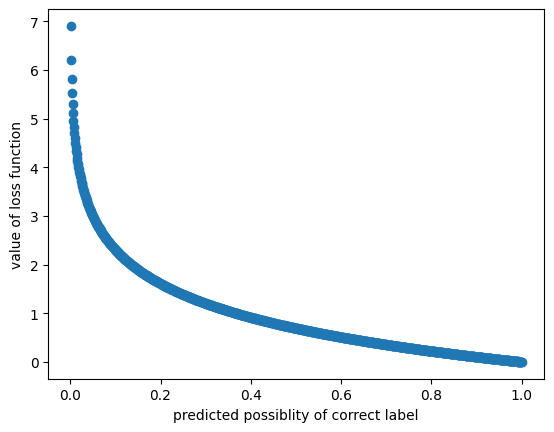

In [113]:
x = np.linspace(0,1,1000)
y = (-1)*np.log(x)
plt.scatter(x,y)
plt.xlabel('predicted possiblity of correct label')
plt.ylabel('value of loss function')

In [114]:
def cross_entropy_error(pred,train):
    pred=pred+(1e-7) #log0の計算にならないように微小な値を足しておく
    return -np.sum(train*np.log(pred))

ここまでの損失関数は、1つのデータ（数字当てなら1つの画像データ）をNNに食わせた時のk個の出力（数値当てなら0~9のそれぞれの確率と正解）に対するエラー。  
実際にはデータがN個あることを考えると、それぞれのデータに対して損失関数の値を計算し、その平均を取った値で学習を進める。  
$$
E = \frac{1}{N} \sum\limits_{n=1}^{N} E_n = \frac{1}{N} \sum\limits_{n=1}^{N} \sum\limits_{k} t_{nk}\log_e{y_{nk}}
$$
ここでの$y_{nk}$はn番目のデータに対するk番目のNN出力の値、$t_{nk}$はn番目のデータのk番目の正解ラベルを表す。

ところで、Nが非常に大きい時の計算負荷が高くなってしまうことを避けるために、訓練データの中からランダムにp個を取得して、その平均を全データの損失関数だとみなして学習を進めるケースがままある。

In [122]:
y_train_oh = OneHotEncoder(sparse_output=False).fit_transform(y_train.reshape(-1, 1))
y_train_oh.shape

(60000, 10)

In [129]:
y_train.size

60000

In [127]:
y_train_oh.ndim

2

In [361]:
p = np.array(
    [
        (0.1,0.1,0.5,0.3),
        (0.7,0.1,0.1,0.1),
    ]
    )
t = np.array([2,3])
if p.ndim==1:
    p=p.reshape(1,p.size)
    t=t.reshape(1,t.size)
batch_size=p.shape[0]
np.log(p[np.arange(batch_size),t])

array([-0.69314718, -2.30258509])

In [366]:
p = np.array(
    [
        (0.1,0.1,0.5,0.3),
        (0.7,0.1,0.1,0.1),
    ]
    )
p.argmax()

4

In [362]:
def cross_entropy_error(pred,train,onehot=False):
    '''
    pred  :NNの予測結果
    train :教師ラベル
    onehot:trainをone hot encodingデータで渡す場合はTrue
    '''
    if onehot: # one hot encodingの正解データが与えられた場合
        # 1つのデータに対する出力が与えられた場合、(1,sample_size)の２次元配列に整形する
        if pred.ndim == 1:
            pred = pred.reshape(1,pred.size)
            train = train.reshape(1,train.size)
        batch_size = pred.shape[0]
        # log0の計算にならないように微小な値を足しておく
        loss = -np.sum(train*np.log(pred+(1e-7)))/batch_size
    else: # 正解データとしてラベルデータが与えられた場合
        if pred.ndim == 1:
            pred = pred.reshape(1,pred.size)
            train = train.reshape(1,train.size)
        batch_size = pred.shape[0]
        # 正解ラベル以外の計算は全て0になることを利用
        loss = - np.sum(np.log(pred[np.arange(batch_size),train]+(1e-7)))/batch_size
    return loss

## 4.3 微分
損失関数を使う理由は、損失関数を最小化する際に、微分の考え方が使えるから。  
NNではシグモイド関数を活性化関数に採用して、損失関数で精度を確認していくことで、各パラメータ（重み、バイアス）を少し変えるだけでも出力や誤差が連続的に推移する。  
そのため、パラメータを微小に変えた時の損失関数の変化（＝損失関数の微分）の正負によってパラメータをどう変えれば損失関数が低下するかを判断することができる。  
損失関数ではなくAccuracyを使って学習しようとすると、パラメータに対して不連続に結果が変わってしまうこと、活性化関数にシグモイドではなくステップ関数を使うと0,1の離散データになってしまうことから、微分不可能になってしまう。  
pythonで微分を実装する場合は、微分の定義に立ち返ってxを微小変化させた時の傾きを計算で求める。  
このようにして求めることを数値微分(numeric differenciation)という。  
$\frac{dx^2}{dx} = 2x$のような数式転換による微分を解析的微分という。  
$$
微分の定義 : \frac{df(x)}{dx} = \lim_{h\to\infty} \frac{f(x+h)-f(x)}{h}
$$

In [135]:
def numeric_diff(f,x):
    h=1e-4 # 微小すぎると丸め誤差が発生する。ノウハウとして10^{-4}
    return (f(x+h)-f(x-h)) / (2*h) # 前方差分よりも誤差が少ない中央差分をとる

数値微分のテクニックとして、xとxから微小期間進んだ点の傾き（前方差分）よりも、  
xを中心に、微小期間手前と微小期間進んだ点の傾き(中央差分)を取った方が解析的微分との誤差が少ない、ということがある。  
以下に$y = f(x) = x^3 +x^2 + x$での例を示す。  
解析的微分は言わずもがな$f'(x) = 3x^2+2x+1$である。

Text(0.5, 1.0, '解析的微分')

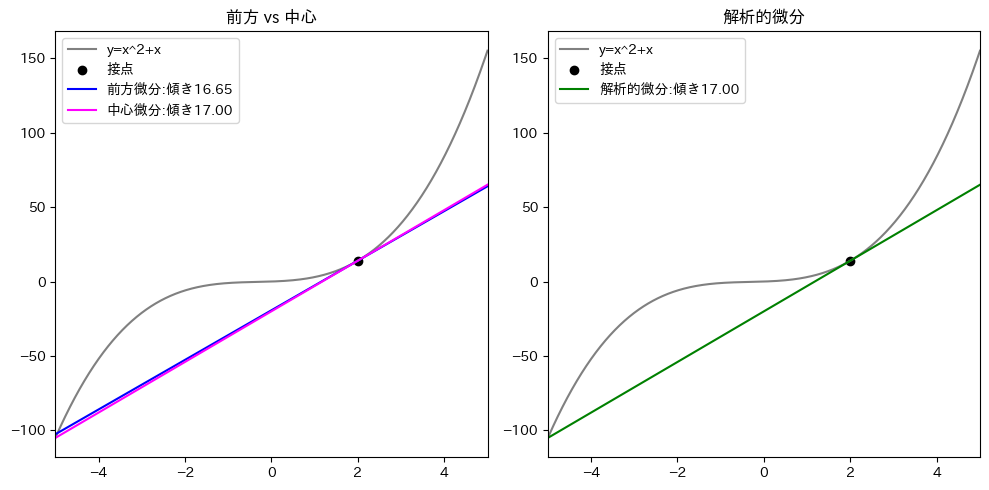

In [211]:
def f(x):
    return x**3 + x**2 + x
def f_anal_diff(x):
    return 3*x**2 + 2*x + 1

x = np.linspace(-5,5,1000)
y = f(x)

h=.05 # 微小期間(わかりやすさのためあえて大きい数値を使っている。)
x_center=2 # x=2の周辺で微分を行う
y_center = f(x_center) # x=2の時のy座標

diff_center = (f(x_center+h)-f(x_center-h)) / (2*h)
diff_front =  (f(x_center)-f(x_center-h)) / (h)
analitic_diff = f_anal_diff(x_center)

diff = [diff_front,diff_center,analitic_diff]
labels = ['前方微分','中心微分','解析的微分']

fig,axes = plt.subplots(1,2,figsize=(10,5),tight_layout=True)

axes[0].plot(x,y,c='gray',label = 'y=x^2+x')
axes[0].scatter(x_center,y_center,c='black',label = '接点')
axes[0].plot(x,diff[0]*(x-x_center)+y_center,c='blue',label=f'{labels[0]}:傾き{np.max(diff[0]):.2f}')
axes[0].plot(x,diff[1]*(x-x_center)+y_center,c='magenta',label=f'{labels[1]}:傾き{np.max(diff[1]):.2f}')
axes[0].set_xlim(-5,5)
axes[0].legend(loc='best')
axes[0].set_title('前方 vs 中心')

axes[1].plot(x,y,c='gray',label = 'y=x^2+x')
axes[1].scatter(x_center,y_center,c='black',label = '接点')
axes[1].plot(x,diff[2]*(x-x_center)+y_center,c='green',label=f'{labels[2]}:傾き{np.max(diff[2]):.2f}')
axes[1].set_xlim(-5,5)
axes[1].legend(loc='best')
axes[1].set_title('解析的微分')

## 4.3 勾配
変数が複数ある関数の微分は、対象とする1つの変数以外を定数とみなして、その1つの変数に対する微分を行う。これを偏微分という。  
$$
\begin{align}
f(x_0,x_1)=x_0^2 + x_1^2 \\
x_0に対する偏微分:\frac{\partial{f}}{\partial{x_0}}=2x_0 \\
x_1に対する偏微分:\frac{\partial{f}}{\partial{x_1}}=2x_1
\end{align}
$$
変数がn個ある関数のそれぞれの変数に対する偏微分をベクトルとしてまとめたものを<ins>**勾配**</ins>という。
$$
f(x_0,x_1)の勾配=\bigg( \frac{\partial{f}}{\partial{x_0}},\frac{\partial{f}}{\partial{x_1}} \bigg)
$$
試しに、以下の実装をしてみる  
$$
\begin{align}
y = f(x_0,x_1)=x_0^2 + x_1^2 \\
x_0 = 3, x_1 = 4の時の勾配
\end {align}
$$


In [239]:
def f(x):
    return x[0]**2 + x[1]**2

def numeric_gradient(f,x):
    # x_0に対する偏微分ではx_1を固定し、x_0-hとx_0+hの差異を求める
    h=1
    gradient = np.zeros_like(x)

    for i in range(x.size):
        org_val = x[i]
        x[i] = org_val - h
        fxh_under = f(x)
        x[i] = org_val + h
        fxh_above = f(x)
        gradient[i] = (fxh_above-fxh_under)/(2*h)
        x[i] = org_val
    return gradient

    # for i in range(x.size):
    #     x_un, x_ab = np.copy(x), np.copy(x)
    #     print(x_ab,x_un)
    #     x_un[i] = x[i] - h
    #     print(x_ab,x_un)
    #     x_ab[i] = x[i] + h
    #     print(x_ab,x_un)
    #     gradient[i] = (f(x_ab)-f(x_un))/(2*h)
    # return gradient

In [240]:
x = np.array([3.0,4.0])
g = numeric_gradient(f,x)
print(g)

[6. 8.]


### 重要：勾配とは？
勾配(のベクトルにマイナスをつけた出力ベクトル)は**各地点**$(x_0,x_1)$**において**$f(x_0,x_1)$を**最も小さくする**$x_0,x_1$の**方向**を指す。  
**その方向が関数の最小値に向かっているとは限らないので注意！**  
少なくともその地点においては、その方向に進むことで関数の値が一番小さくなる、というだけで、真の最小値はそのほかにある可能性は残る。  
以下は$y=x_0^2 + x_1^2$について、いくつかの$(x_0,x_1)$に対する勾配のマイナスベクトルを図示した。  
コードは公式リポジトリから拝借

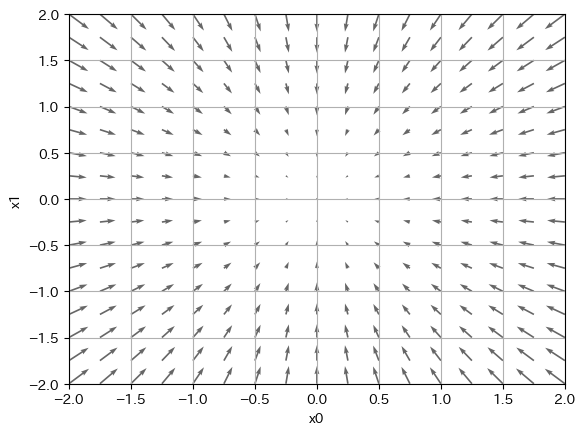

In [242]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(f, np.array([X, Y]).T).T

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.draw()
plt.show()


## 4.4.1 勾配法
ニューラルネットワークの学習は、損失関数の値が最小になるようにパラメータ(隠し層ごと、ニューロンごとの重みとバイアス)をいじりながら進んでいく。  
あるパラメータを使った時、さらに損失関数を小さくするには次にどうすればいいか？を、そのパラメータに対する勾配を計算することで導いていく。  
具体的には、以下のステップ。  
↓あるパラメータセットに対する損失関数の勾配を求める  
↓その勾配の方向に従ってパラメータセットを一定の距離更新して、損失関数を求める  
↓上記を繰り返して勾配が0になったら学習完了  
勾配を利用して、関数の最小値を目指す方法を<ins>**勾配降下法(gradient descent method)**</ins>  
逆に最大を目指す方法を<ins>**勾配上昇法(gradient ascent method)**</ins>という。

$$
購買降下法を用いたパラメータ更新式 = \Bigg \lbrace
  \begin{aligned}
  x_0 = x_0 - η \frac{\partial f}{\partial x_0} \\
  x_1 = x_1 - η \frac{\partial f}{\partial x_1}
  \end{aligned}
$$  
ηは学習率(learning rate)と呼ばれ、勾配法のパラメータ。
大きすぎても小さすぎてもよくなく、実際はいじりながら学習が正しいかを確認していく。

In [294]:
def gradient_desc(
    f,              # 目的関数
    init_x,         # パラメータの初期値
    lr=0.01,        # 学習率
    step_num=100    # パラメータの更新回数
    ):
    x = np.copy(init_x)
    for i in range(step_num):
        grad = numeric_gradient(f,x)
        x -= lr*grad
    return x

def gradient_desc_with_vis(
    f,              # 目的関数
    init_x,         # パラメータの初期値
    ax,
    lr=0.01,        # 学習率
    step_num=100,   # パラメータの更新回数
    ):
    x = np.copy(init_x)
    ax.scatter(x[0],x[1],marker='*',c='blue',s=20,label='start')
    for i in range(step_num):
        grad = numeric_gradient(f,x)
        x -= lr*grad
        ax.scatter(x[0],x[1],marker='o',c='gray',alpha=.5,s=10)
    ax.scatter(x[0],x[1],marker='*',c='magenta',s=20,label = 'end')

    ax.set_xlim(-abs(init_x[0])*1.1,abs(init_x[0])*1.1)
    ax.set_ylim(-abs(init_x[1])*1.1,abs(init_x[1])*1.1)
    return x

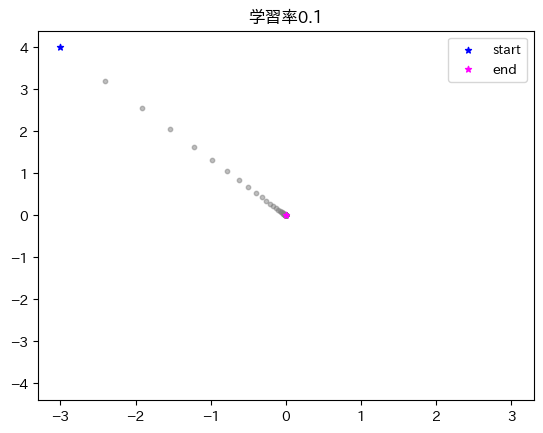

In [292]:
def function(x):
    return x[0]**2 + x[1]**2

def numeric_gradient(f,x):
    # x_0に対する偏微分ではx_1を固定し、x_0-hとx_0+hの差異を求める
    h=1
    gradient = np.zeros_like(x)

    for i in range(x.size):
        org_val = x[i]
        x[i] = org_val - h
        fxh_under = f(x)
        x[i] = org_val + h
        fxh_above = f(x)
        gradient[i] = (fxh_above-fxh_under)/(2*h)
        x[i] = org_val
    return gradient

init_x = np.array([-3.0,4.0])
fig,ax=plt.subplots(1,1)
gradient_desc_with_vis(f=function,init_x=init_x,lr=0.1,step_num=100,ax=ax)
ax.set_title('学習率0.1')
ax.legend(loc='best')

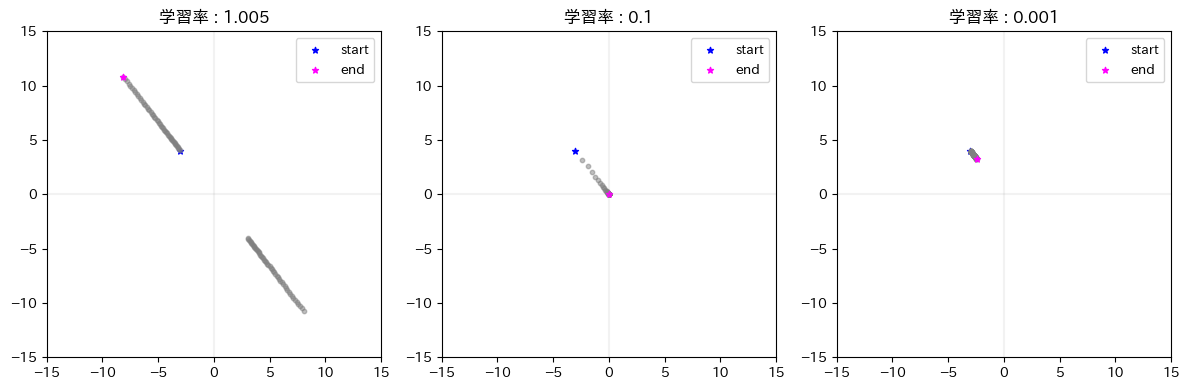

In [317]:
fig,axes = plt.subplots(ncols=3,figsize=(12,4),tight_layout=True)
learning_rates = [1.005,.1,.001]

for ax, lr in zip(axes,learning_rates):
    gradient_desc_with_vis(f=function,init_x=init_x,lr=lr,step_num=100,ax=ax)
    ax.set_title(f'学習率 : {lr}')
    ax.legend(loc='best')
    ax.set_xlim(-15,15)
    ax.set_ylim(-15,15)
    ax.axvline(0,c='gray',alpha=0.1)
    ax.axhline(0,c='gray',alpha=0.1)

重み、バイアスはNNのパラメータであるのに対して、NNのパラメータを探し出すための計算に必要な学習率はハイパーパラメータという

NNの損失関数の勾配を求めてみる。
単純のために、２つの入力に対して隠し層なし、バイアスなしの3つの出力層のNNを考える。
$$
\begin{align}
  X(input)&=(x_1, x_2) \\

  W(weight) &=
    \begin{pmatrix}
      w_{11} & w_{12} & w_{13} \\
      w_{21} & w_{22} & w_{23}
    \end{pmatrix} \\

  Y(output) &= ((x_1w_{11}+x_2w_{21}), (x_1w_{12}+x_2w_{22}), (x_1w_{13}+x_2w_{23})) \\

  gradient &= \frac{\partial Loss}{\partial W} =
    \begin{pmatrix}
      \frac{\partial L}{\partial {w_{11}}} & \frac{\partial L}{\partial {w_{12}}} & \frac{\partial L}{\partial {w_{13}}} \\
      \frac{\partial L}{\partial {w_{21}}} & \frac{\partial L}{\partial {w_{22}}} & \frac{\partial L}{\partial {w_{23}}}
    \end{pmatrix} \\

\end{align}
$$

In [367]:
def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    return exp_a / sum_exp_a

def cross_entropy_error(p,t):
    if p.ndim == 1:
        p = p.reshape(1,p.size)
        t = t.reshape(1,t.size)

    if p.size == t.size: # one hotの場合ラベルに変換
        t = t.argmax(axis=1)

    batch_size = p.shape[0]

    # 正解ラベル以外の計算は全て0になることを利用
    return -np.sum(np.log(p[np.arange(batch_size),t]+(1e-7)))/batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 値を元に戻す
        it.iternext()

    return grad

class SimpleNet():
    def __init__(self):
        self.W = np.random.randn(2,3) #初期パラメータはガウス分布で初期化する

    def predict(self,x):
        return np.dot(x,self.W)

    def loss(self,x,train):
        output = self.predict(x)
        pred = softmax(output)
        return cross_entropy_error(pred,train)

In [369]:
np.random.seed(0)
net = SimpleNet()
x = np.array([4,9])
t= np.array([0,0,1])
p=net.predict(x)
loss_val=net.loss(x,t)

print('重み')
print(net.W)
print('入力')
print(x)
print('出力')
print(net.predict(x))
print(f'正解は{np.argmax(train)}で予測値は{np.argmax(pred)}')
print(f'損失関数の出力は{loss_val:.2f}')

重み
[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]]
入力
[4 9]
出力
[27.22424818 18.40865074 -4.88054898]
正解は2で予測値は0
損失関数の出力は16.12


In [373]:
# def f(W):
#     return net.loss(x,t)

f = lambda W: net.loss(x,t)

dW = numerical_gradient(f,net.W)
dW

array([[ 4.56026328e-07,  7.10542736e-11, -4.56097382e-07],
       [ 1.02607700e-06,  1.59872116e-10, -1.02621911e-06]])

$\frac{\partial{L}}{\partial{w_{xy}}}$は、$w_xy$を$h$増加させると損失関数の値は$h \times \frac{\partial{L}}{\partial{w_{xy}}}$だけ**増加する**ことを表す。  
今は**減少**させたいので、この値をマイナス方向に更新していく・

## 4.5 実装！

ここまでの復習  
ニューラルネットワークでは、重みとバイアスというパラメータがある。  
学習とは、訓練データを用いて、入力が適切な出力になるようにパラメータを最適化させることをいう。  
学習の過程は以下の通り。  
1. ミニバッチ  
訓練データ全体からランダムに適当なデータを取得する。  
取得したデータに対する損失関数を最小化するという方針。  
1. 勾配の算出  
各パラメータについて勾配を計算する  
1. パラメータの更新  
算出されたパラメータごとの勾配に基づいて、微少量パラメータを動かす  
1. 上記をくりかえす  

上記のように、全データから確率的にいくつか選んで勾配降下法を行うことを、確率的勾配降下法という。  
Stochastic Gradient Descentの頭文字をとって、SGDと呼ばれる  

---

実装は、隠れ層1＋出力層の計2層のNNで行う

In [374]:
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet(object):
    def __init__(
        self,
        imput_size,
        hidden_size,
        output_size,
        weight_init_std = 0.01,
        ):

        # 重み初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(imput_size,hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size,output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self,x):
        W1,W2 = self.params['W1'],self.params['W2']
        b1,b2 = self.params['b1'],self.params['b2']
        a1 = np.dot(x,self.params['W1']) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1,W2) + b2
        return softmax(a2)

    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        sample_size = x.shape[0]
        y = self.predict(x)
        y = np.argmax(y,axis=1)
        t = np.argmax(t,axis=1)
        return np.sum(y==t)/sample_size

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        # それぞれのパラメータに対して勾配を計算する。
        grads['W1'] = numerical_gradient(loss_W,self.params['W1'])
        grads['b2'] = numerical_gradient(loss_W,self.params['b2'])
        grads['W1'] = numerical_gradient(loss_W,self.params['W1'])
        grads['b2'] = numerical_gradient(loss_W,self.params['b2'])
        return grads

In [383]:
with open('./mnist/mnist.pkl', 'rb') as f:
    dataset =pickle.load(f)
dataset['train_label'] = OneHotEncoder(sparse_output=False).fit_transform(dataset['train_label'].reshape(-1, 1))
dataset['train_img'] = dataset['train_img'] / 255
dataset['test_label'] = OneHotEncoder(sparse_output=False).fit_transform(dataset['test_label'].reshape(-1, 1))
dataset['test_img'] = dataset['test_img'] / 255